In [7]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [8]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])
# raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [9]:
#Lines from the file of Clean lines
# raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\Nave Fe I_NIR.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\Nave Fe I list_VIS.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


In [10]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,4060.857814,0.303661,4060.8601
1,4068.420377,0.205213,4068.4198
2,4080.988952,0.179634,4080.9899
3,4086.158769,0.218044,4086.1573
4,4088.248370,0.279245,4088.2476
...,...,...,...
613,10425.898921,0.865645,10425.8870
614,10426.603171,0.828575,10426.6020
615,10535.134792,0.693674,10535.1220
616,10580.039381,0.901596,10580.0390


In [11]:
#Localize the line and save the width for each one
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05) #The range is 0.05mA

In [12]:
def arrange_lambda(wave_index, local_points):

    data = local_points[wave_index]

    down = min(data['Wave A'].index)
    up = max(data['Wave A'].index)

    new_data= []

    while len(data)>10:
        data = data.loc[down:up]
        new_data.append(data)

        #Update the cycle
        up -= 1
        down += 1
        
    return new_data

new_local_points = arrange_lambda(0, local_points)

In [13]:
def Fit_derivates(local_points,wave):
    values = []
    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values, taking into account the number of points defined on the covariance matrix
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/wave) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift,line depth
            values.append(pd.DataFrame([[wave,lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift,1-lamda_obs[1],len(local_points[i])]])) 


    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift",'Line Depth','Points']

    return Values

# Values = Fit_derivates(new_local_points,closer_lines['Fe line'].iloc[0])



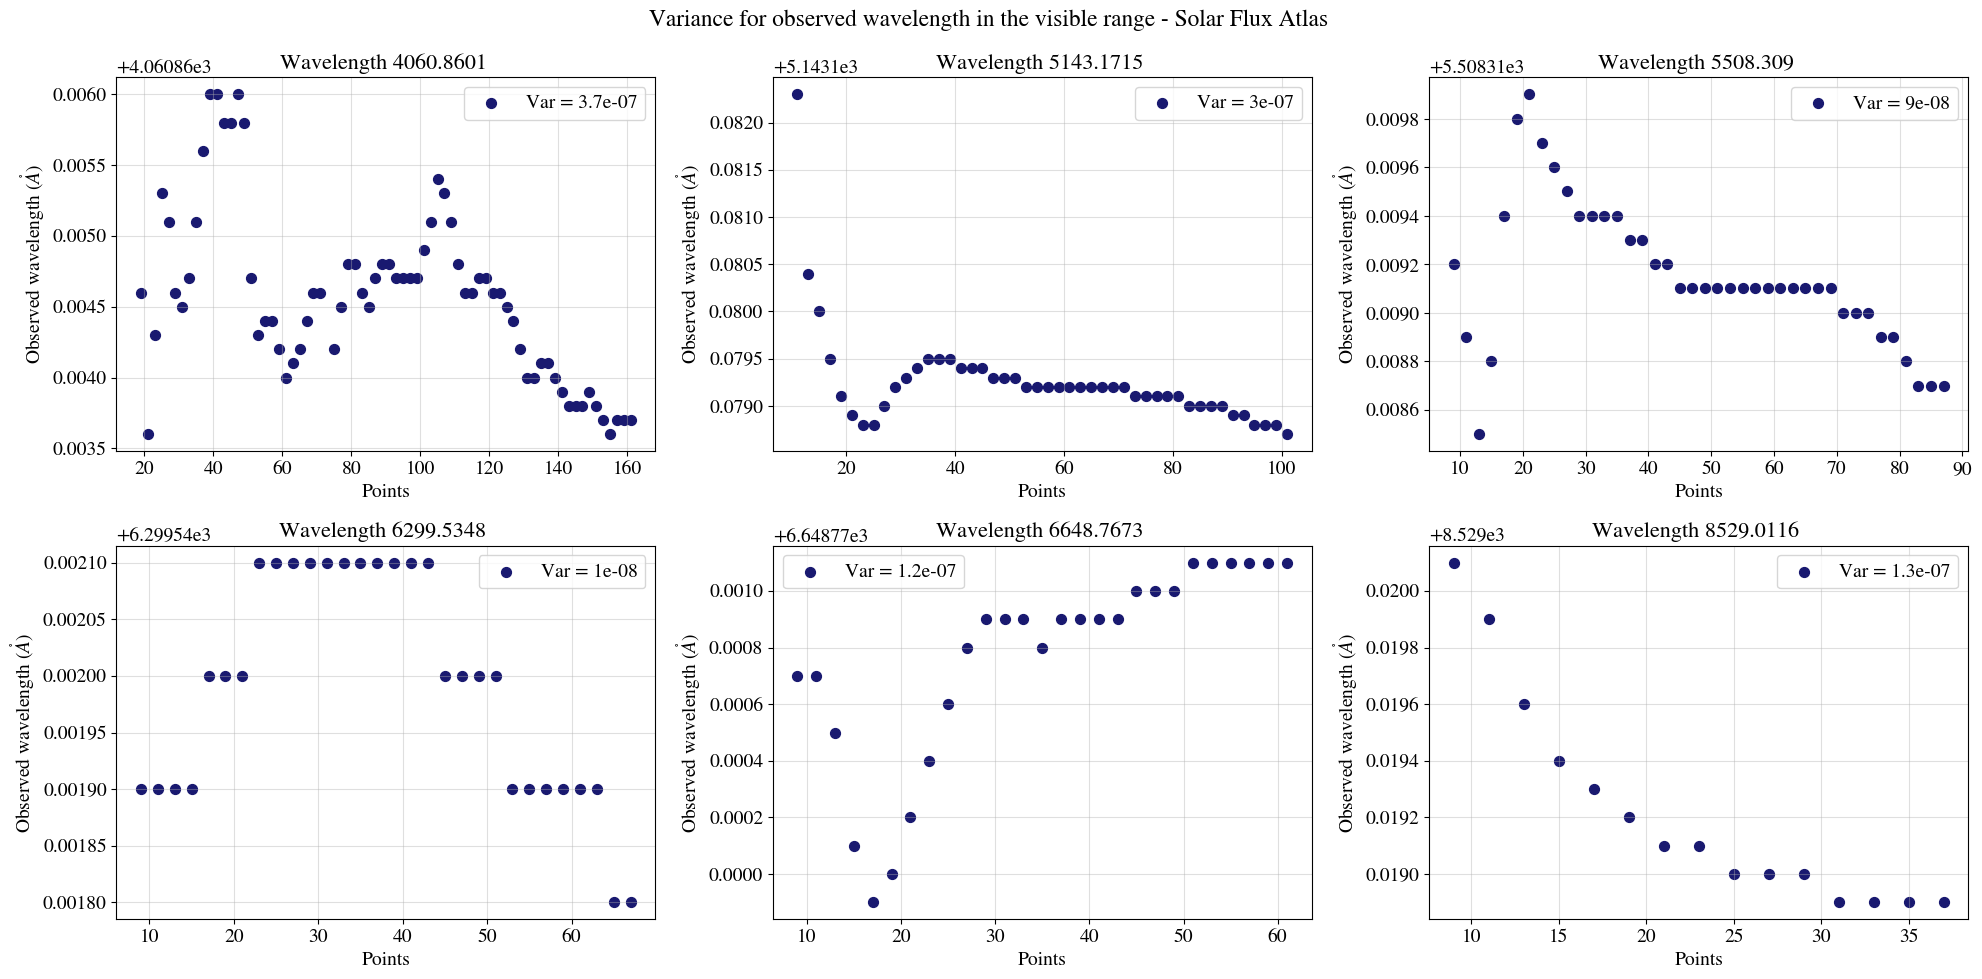

In [14]:
list_index = [0,172,235,378,420,538]

fig5, axes = plt.subplots(2,3,figsize=(20,10))
fig5.suptitle('Variance for observed wavelength in the visible range - Solar Flux Atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):

    new_local_points = arrange_lambda(list_index[i], local_points)
    Values = Fit_derivates(new_local_points,closer_lines['Fe line'].iloc[list_index[i]])
    Values = Values[Values['Velocity']<700 ]
    Values = Values[Values['Velocity']>-700 ]
    # Values = Values[Values['Points']>60 ]
    variance = np.var(Values['Observed wavelength'])

    ax.scatter(Values['Points'],Values["Observed wavelength"],label = 'Var = {}'.format(round(variance,8)),c='midnightblue',s=50) 

    ax.set_title(r'Wavelength {} '.format(Values["Emitted wavelength"].iloc[0]))   
    ax.set_ylabel(r'Observed wavelength $(\mathring{A})$')
    ax.set_xlabel(r'Points')
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance VIS')

Now, check the variance of the mean altering the window of the line

In [20]:
def Uncertainties(local_points):
    values = []
    for i in range(0,len(local_points)):

        data_wave = local_points[i]['Wave A'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        
        values.append(pd.DataFrame([[wave_mean,wave_std]]))

    values = pd.concat(values,axis=0)
    values.columns = ['Mean','Std']
    values = values.reset_index(drop=True)

    return values

steps = np.arange(0,0.1,0.01)
values_mean = []
values_std = []
for each in steps:
    local_points = width_minimums(closer_lines.loc[0:150],raw_data,0.05 + each)
    values_mean.append(Uncertainties(local_points)['Mean'])
    values_std.append(Uncertainties(local_points)['Std'])

# values_mean[0]

values_std#Hay que optimizar tal vez programación en paralelo

[0      0.028867
 1      0.028975
 2      0.028792
 3      0.028865
 4      0.028894
          ...   
 146    0.029122
 147    0.029133
 148    0.028603
 149    0.028622
 150    0.028727
 Name: Std, Length: 151, dtype: float64,
 0      0.034605
 1      0.034734
 2      0.034587
 3      0.034674
 4      0.034710
          ...   
 146    0.034566
 147    0.034579
 148    0.034596
 149    0.034619
 150    0.034747
 Name: Std, Length: 151, dtype: float64,
 0      0.040343
 1      0.040493
 2      0.040382
 3      0.040484
 4      0.040525
          ...   
 146    0.040554
 147    0.040569
 148    0.040589
 149    0.040617
 150    0.040219
 Name: Std, Length: 151, dtype: float64,
 0      0.046080
 1      0.046252
 2      0.046176
 3      0.046293
 4      0.046341
          ...   
 146    0.045998
 147    0.046015
 148    0.046038
 149    0.046069
 150    0.046239
 Name: Std, Length: 151, dtype: float64,
 0      0.051818
 1      0.052011
 2      0.051971
 3      0.052103
 4      0.051793
   

In [16]:
width_minimums(closer_lines[0:1],raw_data,0.05 )

[          Wave (cm)     nFlux     rFlux       Wave A
 19765  24625.640250  0.805883  0.002101  4060.808125
 19766  24625.636484  0.785722  0.002121  4060.808746
 19767  24625.632717  0.772221  0.002116  4060.809367
 19768  24625.628951  0.773272  0.002075  4060.809988
 19769  24625.625184  0.784487  0.002018  4060.810609
 ...             ...       ...       ...          ...
 19921  24625.052671  0.590078  0.002111  4060.905020
 19922  24625.048904  0.618959  0.002057  4060.905641
 19923  24625.045138  0.650750  0.002013  4060.906262
 19924  24625.041371  0.653284  0.002030  4060.906883
 19925  24625.037605  0.637190  0.002096  4060.907504
 
 [161 rows x 4 columns]]

Now, check the variance of the mean altering the window of the line